In [1]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

import torch
torch.set_float32_matmul_precision('high')

In [2]:
# Import the relevant modules
import sousvide.synthesize.rollout_generator as rg
import sousvide.synthesize.observation_generator as og
import sousvide.instruct.train_policy as tp
import sousvide.visualize.plot_synthesize as ps
import sousvide.visualize.plot_learning as pl
import sousvide.flight.deploy_figs as df

In [8]:
cohort = "flight_path"             # cohort name

data_method = "data_alpha"        # method name
# data_method = "data_beta"        # method name
# data_method = "eval_single"         # method name
# eval_method = "eval_single"        # method name
eval_method = "eval_nominal"        # method name

scene = "mid_gate"                  # scene name

courses = [                         # course names
    # "hover",
    # "line",
    "robustness_track",
    ]   

roster = [
    "Maverick",
    # "hsDavion",
    # "hsKurita",
    # "hsLiao",
    # "hsMarik",
    # "hsSteiner"
    ]


In [ ]:
# Generate Rollouts
rg.generate_rollout_data(cohort,courses,scene,data_method)

# Review the Rollout Data
ps.plot_rollout_data(cohort)

In [ ]:
# Generate initial observation data sets
og.generate_observation_data(cohort,roster)

In [ ]:
tp.train_roster(cohort,roster,"featNet",100,regen=False)

pl.plot_losses(cohort,roster,"featNet")

In [ ]:
# Second Stage Training
tp.train_roster(cohort,["hsKurita"],"featNet",70,regen=False)

pl.plot_losses(cohort,["hsKurita"],"featNet")

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/mid_gate/splatfacto/2024-10-07_145741/nerfstudio_models/step-000029999.ckpt

Plotting trajectories for expert...

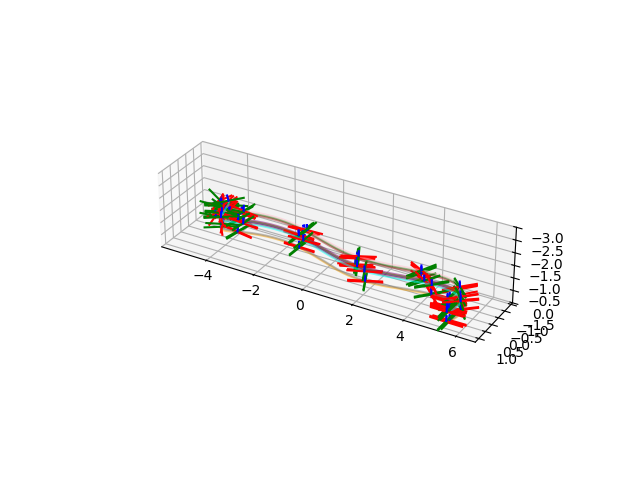

Plotting trajectories for Maverick...

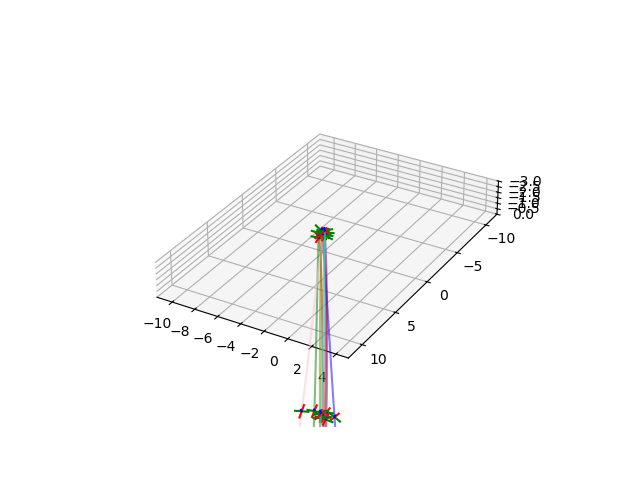

                      Deployment Summary                      
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓
┃ Pilot    ┃ TTE Mean ┃ TTE Best ┃  PP  ┃ Hz Mean ┃ Hz Worst ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩
│ expert   │   0.26   │   0.08   │ 0.79 │ 198.23  │  39.80   │
│ Maverick │  327.24  │  297.60  │ 0.01 │ 324.93  │  41.88   │
└──────────┴──────────┴──────────┴──────┴─────────┴──────────┘

In [9]:
# Simulate in FiGS
for course in courses:
    df.deploy_roster(cohort,course,scene,eval_method,roster,mode="visualize")
    pl.plot_deployments(cohort,course,roster,plot_show=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

workpath = "/home/admin/Personal/Kitchen/cohorts/flight_path/observation_data/hsDavion/"

data = []
for i in range(5):
    data_feat = torch.load(workpath + "featNet/robustness_track/observations00" + str(i+1) + ".pt")
    data_comm = torch.load(workpath + "commNet/robustness_track/observations00" + str(i+1) + ".pt")

    for xnn,ynn in zip(data_feat["Ynn"],data_comm["Ynn"]):
        data.append((xnn,ynn))

    # for xnn,ynn in zip(data_comm["Xnn"],data_comm["Ynn"]):
    #     data.append((xnn[0],ynn))

# Define a custom dataset
class ObservationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=20, output_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ObservationDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model = SimpleMLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
Losses = []
for epoch in range(200):
    total_loss = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{200}, Loss: {total_loss/len(data):.4f}")
    Losses.append(total_loss/len(data))

In [ ]:
# Plot the losses
plt.figure(figsize=(5, 3))
plt.plot(Losses)
plt.show()
print("Final Loss: ", Losses[-1])

In [ ]:
X = torch.randn(10, 2)
y = torch.randint(0, 3, (10,))

print(X)
print(y)